In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

___
# Making NFkB Pathway Correlation Figure

First we need to extract the actual gene expression signatures from our cpds and from the KDs of the genes in the NFkB pathway.

In [2]:
# extract cpd signatures
cpd_ids = ['BRD-K95352812','BRD-A09719808']
consensi_df = pd.DataFrame.from_csv('data/consensi-pert_id.tsv', sep='\t', header=0).T
cpd_signatures = consensi_df[cpd_ids].copy()

# extract KD signatures (from positively correlating genes)
NFkB_KDs=['TRAF5','RIPK1','UBE2D1','UBB','UBC','TAB2','MAP3K7','RBCK1']
KD_consensi_df = pd.DataFrame.from_csv('data/KD_consensus_sigs.csv', header=0).T
KD_signatures = KD_consensi_df[NFkB_KDs].copy()

In [3]:
# combine into single dataframe for convenience
cpd_kd_sigs = pd.concat([cpd_signatures, KD_signatures], axis = 1)

Currently the expression vectors are indexed by gene ID, which isn't very interpretable. Let's replace these IDs with the actual gene symbols for each expression value.

In [6]:
LINCS_gene_df = pd.DataFrame.from_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
gene_mapping = LINCS_gene_df.loc[cpd_kd_sigs.index.astype(int)]['pr_gene_symbol']
cpd_kd_sigs['gene'] = gene_mapping.values
cpd_kd_sigs = cpd_kd_sigs.set_index('gene')

Now lets filter our expression vectors to select expression levels of genes known to interact with TRAF2.

In [7]:
# extract TRAF2 interaction partners from Biogrid.
Biogrid_df = pd.DataFrame.from_csv('data/BIOGRID-GENE-113038-3.4.153.tab2.txt', sep='\t', header=0)
TRAF2_partner_genes = set(Biogrid_df[['Official Symbol Interactor A','Official Symbol Interactor B']].values.flatten())

# find out which partners are measured in LINCS signatures
landmark_genes = set(gene_mapping.values)
pathway_genes = list(TRAF2_partner_genes & landmark_genes)

# refine expression vectors
cpd_kd_filtered_sigs = cpd_kd_sigs.loc[pathway_genes].copy()

Now we want to sort these genes by their average relative expression level 

In [8]:
cpd_kd_filtered_sigs['mean'] = np.mean(cpd_kd_filtered_sigs, axis=1)
cpd_kd_filtered_sigs.sort_values('mean', ascending=False, inplace=True)
cpd_kd_filtered_sigs.head()

perturbagen,BRD-K95352812,BRD-A09719808,TRAF5,RIPK1,UBE2D1,UBB,UBC,TAB2,MAP3K7,RBCK1,mean
gene,,,,,,,,,,,
JUN,7.538,18.279,4.431,3.500,0.565,2.761,5.185,0.675,1.294,0.650,4.4878
ZFP36,9.760,11.376,2.897,3.394,2.130,3.755,2.053,2.022,4.315,0.162,4.1864
NFIL3,11.001,13.187,-0.889,1.141,0.350,1.687,2.772,3.095,2.978,-3.799,3.1523
PSMF1,2.029,1.935,3.086,3.468,0.597,3.967,3.524,3.473,1.458,2.464,2.6001
DNAJB2,5.865,7.583,1.772,-1.081,3.678,-1.520,1.626,1.758,0.752,1.486,2.1919


___
# Now we want to make the figure

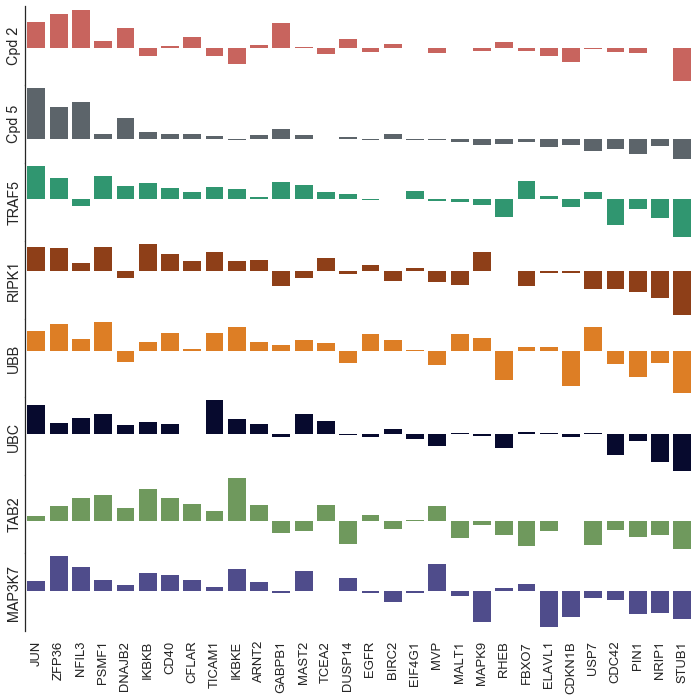

In [45]:
# setup figure
sns.set(style="white", context="talk")
f, (ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9,) = plt.subplots(8, 1, figsize=(10, 10), sharex=True)

# extract the data
x = cpd_kd_filtered_sigs.index.values
[y1,y2,y3,y4,y5,y6,y7,y8,y9,y10] = cpd_kd_filtered_sigs.iloc[:,0:10].T.values

# plot the data
sns.barplot(x, y1, color=sns.xkcd_rgb["pale red"], ax=ax1)
sns.barplot(x, y2, color=sns.xkcd_rgb["slate grey"], ax=ax2)
sns.barplot(x, y3, color=sns.xkcd_rgb["jade"], ax=ax3)
sns.barplot(x, y4, color=sns.xkcd_rgb["russet"], ax=ax4)
#sns.barplot(x, y5, color=sns.xkcd_rgb["cerulean blue"], ax=ax5)
sns.barplot(x, y6, color=sns.xkcd_rgb["pumpkin orange"], ax=ax6)
sns.barplot(x, y7, color=sns.xkcd_rgb["dark navy"], ax=ax7)
sns.barplot(x, y8, color=sns.xkcd_rgb["off green"], ax=ax8)
sns.barplot(x, y9, color=sns.xkcd_rgb["blueberry"], ax=ax9)
#sns.barplot(x, y10, color=sns.xkcd_rgb["tomato"], ax=ax10)

# label the subplots
ax1.set_ylabel("Cpd 2")
ax2.set_ylabel("Cpd 5")
ax3.set_ylabel("TRAF5")
ax4.set_ylabel("RIPK1")
#ax5.set_ylabel("UBE2D1")
ax6.set_ylabel("UBB")
ax7.set_ylabel("UBC")
ax8.set_ylabel("TAB2")
ax9.set_ylabel("MAP3K7")
#ax10.set_ylabel("RBCK1")

sns.despine(bottom=True)
plt.xticks(rotation='vertical')
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=0)
plt.show()